# Setup enviorment

In [1]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, preprocess_dataset_to_time_series

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [2]:
""" Read Dataset:"""

embeddings = 'Embeddings/variational_autoencoder_224_1024.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T=3
autoregressive = True
feature_range = (-1, 1)
fusion = 'joint'

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='GRU'
bidirectional=False

## 1. Read Data

In [3]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

## 2. Preprocessing

### Train Test split

In [4]:
train_df = dengue_df[:int(len(dengue_df)*(train_percentage/100))]
Municipalities_train = Municipalities[:int(len(dengue_df)*(train_percentage/100))]
test_df = dengue_df[int(len(dengue_df)*(train_percentage/100)):]
Municipalities_test = Municipalities[int(len(dengue_df)*(train_percentage/100)):]
#test_df

### Normalize features

In [5]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities_train)
test_df = pd.concat(test_df, keys=Municipalities_test)

In [6]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities_train]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546 -0.152315 -0.008257  0.124823 -0.438372 -0.115707 -0.225058   
      201547 -0.429644 -0.180829  0.091231  0.321699  0.151782  0.138723   
      201548 -0.161068  0.576082 -0.436528  0.165498  0.241237  0.042973   
      201549 -0.260170  0.167611 -0.410230  0.064991  0.048733  0.131852   
      201550  0.441330  0.225024 -0.081751 -0.672187  0.065666 -0.758178   

                     6         7         8         9  ...      1015      1016  \
41001 201546 -0.473106 -0.368344 -0.407803  0.184894  ... -0.078890  0.103824   
      201547 -0.128355 -0.300411  0.658483 -0.437008  ...  0.314439  0.368487   
      201548  0.055301 -0.306384 -0.244395  0.053250  ...  0.455030 -0.227580   
      201549 -0.398770 -0.091087  0.217093 -0.104882  ... -0.287345  0.278916   
      201550  0.085061 -0.633349  0.213285  0.176507  ...  0.162102 -0.204953   

                  1017      1018      1019      1020      1021      1022  \
41001 201546  0.726407 -0.460573 -0.098291 -0.444475  0.310875  0.038217   
      201547  0.963722  0.200345 -0.157422 -0.599799 -0.170341 -0.038084   
      201548 -0.136099 -0.016585  0.391008  0.751067  0.211474  0.286467   
      201549  0.106186  0.005580  0.201473 -0.214119  0.614926 -0.359967   
      201550  0.413980 -0.400370 -0.097594 -0.198839 -0.752909 -0.144777   

                  1023    Labels  
41001 201546  0.056886 -0.861740  
      201547 -0.595335 -0.854589  
      201548 -0.406842 -0.856973  
      201549  0.149468 -0.856973  
      201550  0.328874 -0.823600  

[5 rows x 1025 columns]

In [7]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities_test]

test_df[1].head()

0         1         2         3         4         5  \
5360 201546  0.186118 -0.467990  0.435267  0.347558  0.223379 -0.092600   
     201547 -0.031743  0.128215 -0.254998  0.266815 -0.474168 -0.156857   
     201548 -0.109709  0.166347 -0.013395 -0.174514 -0.390162 -0.349858   
     201549  0.359992  0.546292  0.127535 -0.222885 -0.547900 -0.011747   
     201550  0.137245 -0.345681 -0.045487 -0.131272 -0.013486  0.008818   

                    6         7         8         9  ...      1015      1016  \
5360 201546  0.222575 -0.090122 -0.288593  0.422614  ...  0.060105  0.443189   
     201547 -0.358710 -0.129209 -0.221991  0.871192  ... -0.279091  0.047074   
     201548 -0.130038 -0.177032  0.483901  0.582196  ...  0.597011  0.044982   
     201549 -0.106706  0.215504  0.036656  0.341239  ... -0.498720 -0.400292   
     201550  0.253216 -0.028422 -0.046990 -0.039587  ...  0.253952  0.262296   

                 1017      1018      1019      1020      1021      1022  \
5360 201546  0.036510 -0.045586 -0.175214 -0.099030 -0.193360 -0.066682   
     201547  0.327831  0.101820 -0.175938  0.752862  0.237860 -0.738861   
     201548  0.273295 -0.035685 -0.085753 -0.327600  0.082075 -0.375873   
     201549  0.091562  0.163436 -0.452942  0.085359 -0.203362 -0.128735   
     201550 -0.078173 -0.191487  0.303004 -0.286701 -0.399233 -0.221834   

                 1023    Labels  
5360 201546 -0.025980 -0.990465  
     201547 -0.068780 -0.969011  
     201548  0.414215 -0.995232  
     201549 -0.053798 -0.997616  
     201550 -0.209901 -0.971395  

[5 rows x 1025 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [8]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(160, 4100)

### Merge train data

In [9]:
# Merge:
train = pd.concat(train, keys=Municipalities_train)
test = pd.concat(test, keys=Municipalities_test)

### Features and Labels Set

In [10]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1280, 3075)
The shape of the labels is (1280, 1)
Test:
The shape of the features is (320, 3075)
The shape of the labels is (320, 1)


In [11]:
# reshape input to be 3D [samples, timesteps, features]
train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

The initial shapes are:
The train shape is (1280, 3075)
The test shape is (320, 3075)
-----------------------
The Final shapes are:
The train shape is (1280, 3, 1025)
The test shape is (320, 3, 1025)


# 2. Model

In [12]:
x_ar = train_X[:, :, -1:]
x_ar_test = test_X[:, :, -1:]

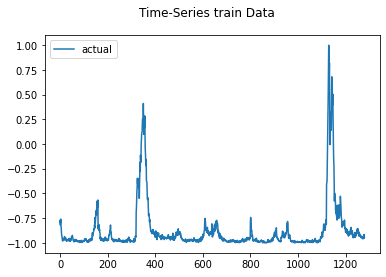

2023-03-06 20:59:02.364905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-06 20:59:02.364954: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-06 20:59:02.364978: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-06 20:59:02.365213: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 20:59:07.119299: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_input (InputLayer)          [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_2_input (InputLayer)        [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1)            8492971     gru_input[0][0]                  
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1)            5420971     gru_2_input[0][0]                
______________________________________________________________________________________________

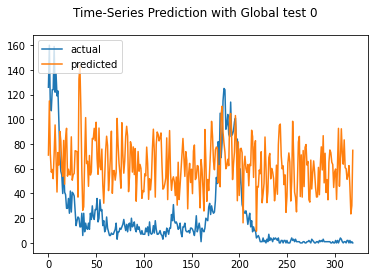

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_4_input (InputLayer)        [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_6_input (InputLayer)        [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 1)            8492971     gru_4_input[0][0]                
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 1)            5420971     gru_6_input[0][0]                
________

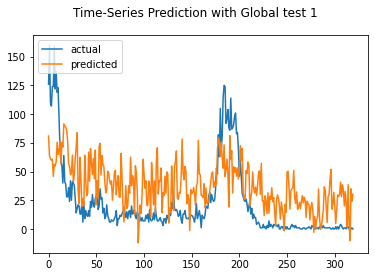

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_8_input (InputLayer)        [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_10_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 1)            8492971     gru_8_input[0][0]                
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 1)            5420971     gru_10_input[0][0]               
____________________________________________________________________________________________

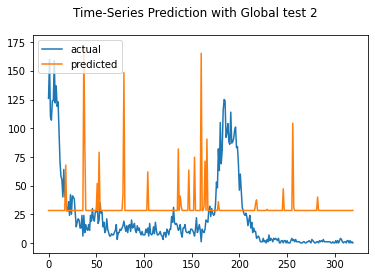

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_12_input (InputLayer)       [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_14_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 1)            8492971     gru_12_input[0][0]               
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 1)            5420971     gru_14_input[0][0]               
____________________________________________________________________________________________

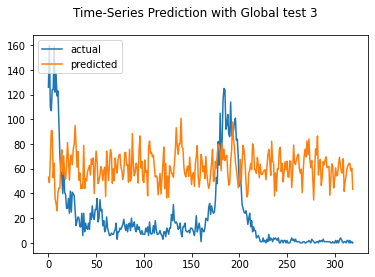

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_16_input (InputLayer)       [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_18_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 1)            8492971     gru_16_input[0][0]               
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 1)            5420971     gru_18_input[0][0]               
____________________________________________________________________________________________

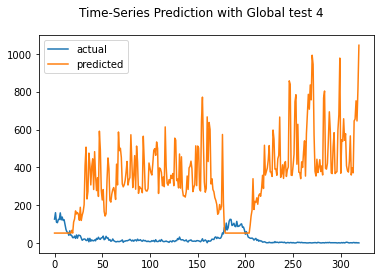

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_20_input (InputLayer)       [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_22_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 1)            8492971     gru_20_input[0][0]               
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 1)            5420971     gru_22_input[0][0]               
____________________________________________________________________________________________

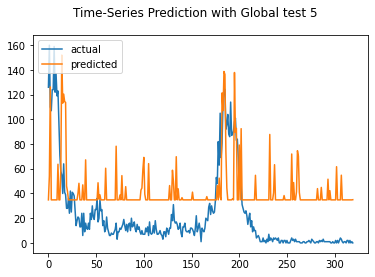

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_24_input (InputLayer)       [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_26_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 1)            8492971     gru_24_input[0][0]               
__________________________________________________________________________________________________
sequential_13 (Sequential)      (None, 1)            5420971     gru_26_input[0][0]               
________

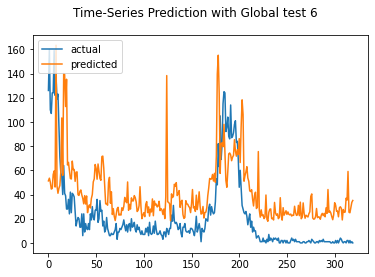

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_28_input (InputLayer)       [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_30_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_14 (Sequential)      (None, 1)            8492971     gru_28_input[0][0]               
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 1)            5420971     gru_30_input[0][0]               
________

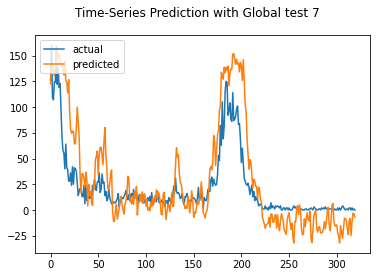

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_32_input (InputLayer)       [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_34_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_16 (Sequential)      (None, 1)            8492971     gru_32_input[0][0]               
__________________________________________________________________________________________________
sequential_17 (Sequential)      (None, 1)            5420971     gru_34_input[0][0]               
____________________________________________________________________________________________

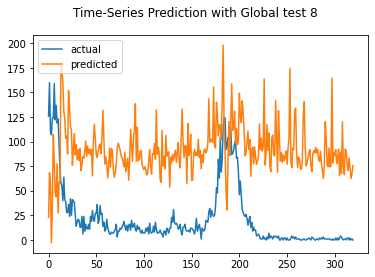

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_36_input (InputLayer)       [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_38_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_18 (Sequential)      (None, 1)            8492971     gru_36_input[0][0]               
__________________________________________________________________________________________________
sequential_19 (Sequential)      (None, 1)            5420971     gru_38_input[0][0]               
________

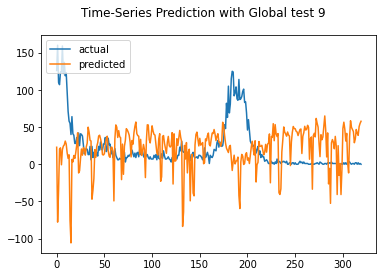

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_40_input (InputLayer)       [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_42_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_20 (Sequential)      (None, 1)            8492971     gru_40_input[0][0]               
__________________________________________________________________________________________________
sequential_21 (Sequential)      (None, 1)            5420971     gru_42_input[0][0]               
_______

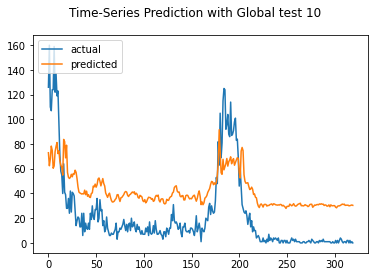

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_44_input (InputLayer)       [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_46_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_22 (Sequential)      (None, 1)            8492971     gru_44_input[0][0]               
__________________________________________________________________________________________________
sequential_23 (Sequential)      (None, 1)            5420971     gru_46_input[0][0]               
___________________________________________________________________________________________

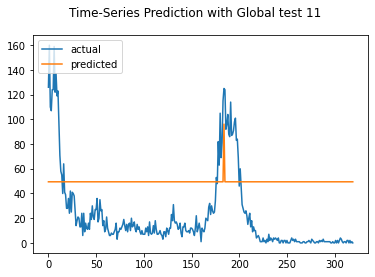

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_48_input (InputLayer)       [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_50_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_24 (Sequential)      (None, 1)            8492971     gru_48_input[0][0]               
__________________________________________________________________________________________________
sequential_25 (Sequential)      (None, 1)            5420971     gru_50_input[0][0]               
_______

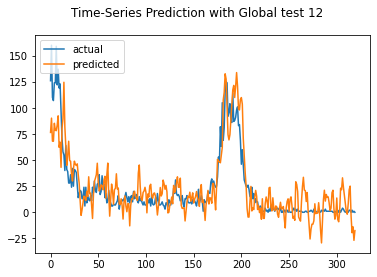

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_52_input (InputLayer)       [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_54_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_26 (Sequential)      (None, 1)            8492971     gru_52_input[0][0]               
__________________________________________________________________________________________________
sequential_27 (Sequential)      (None, 1)            5420971     gru_54_input[0][0]               
___________________________________________________________________________________________

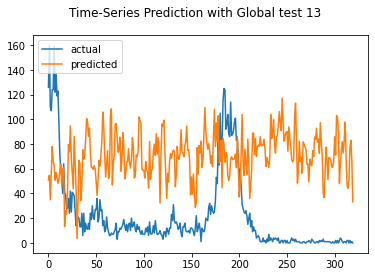

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_56_input (InputLayer)       [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_58_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_28 (Sequential)      (None, 1)            8492971     gru_56_input[0][0]               
__________________________________________________________________________________________________
sequential_29 (Sequential)      (None, 1)            5420971     gru_58_input[0][0]               
_______

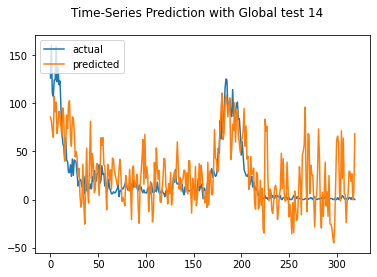

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_60_input (InputLayer)       [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_62_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_30 (Sequential)      (None, 1)            8492971     gru_60_input[0][0]               
__________________________________________________________________________________________________
sequential_31 (Sequential)      (None, 1)            5420971     gru_62_input[0][0]               
_______

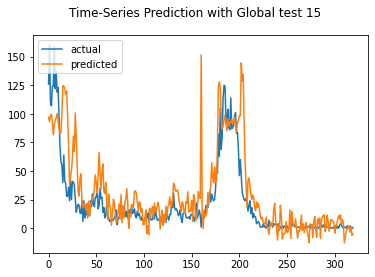

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_64_input (InputLayer)       [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_66_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_32 (Sequential)      (None, 1)            8492971     gru_64_input[0][0]               
__________________________________________________________________________________________________
sequential_33 (Sequential)      (None, 1)            5420971     gru_66_input[0][0]               
_______

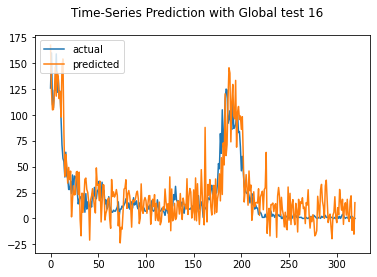

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_68_input (InputLayer)       [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_70_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_34 (Sequential)      (None, 1)            8492971     gru_68_input[0][0]               
__________________________________________________________________________________________________
sequential_35 (Sequential)      (None, 1)            5420971     gru_70_input[0][0]               
___________________________________________________________________________________________

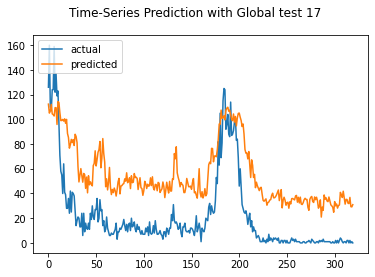

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_72_input (InputLayer)       [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_74_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_36 (Sequential)      (None, 1)            8492971     gru_72_input[0][0]               
__________________________________________________________________________________________________
sequential_37 (Sequential)      (None, 1)            5420971     gru_74_input[0][0]               
_______

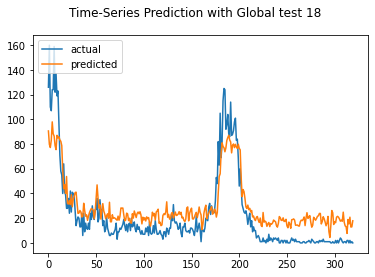

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_76_input (InputLayer)       [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_78_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_38 (Sequential)      (None, 1)            8492971     gru_76_input[0][0]               
__________________________________________________________________________________________________
sequential_39 (Sequential)      (None, 1)            5420971     gru_78_input[0][0]               
___________________________________________________________________________________________

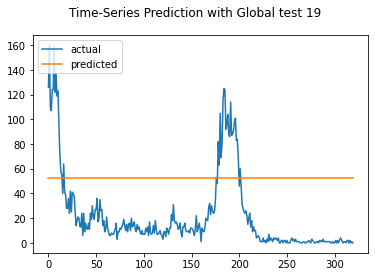

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_80_input (InputLayer)       [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_82_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_40 (Sequential)      (None, 1)            8492971     gru_80_input[0][0]               
__________________________________________________________________________________________________
sequential_41 (Sequential)      (None, 1)            5420971     gru_82_input[0][0]               
_______

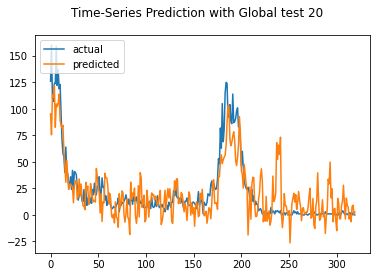

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_84_input (InputLayer)       [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_86_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_42 (Sequential)      (None, 1)            8492971     gru_84_input[0][0]               
__________________________________________________________________________________________________
sequential_43 (Sequential)      (None, 1)            5420971     gru_86_input[0][0]               
_______

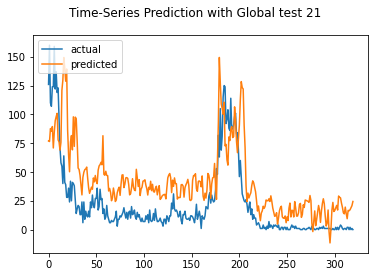

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_88_input (InputLayer)       [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_90_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_44 (Sequential)      (None, 1)            8492971     gru_88_input[0][0]               
__________________________________________________________________________________________________
sequential_45 (Sequential)      (None, 1)            5420971     gru_90_input[0][0]               
___________________________________________________________________________________________

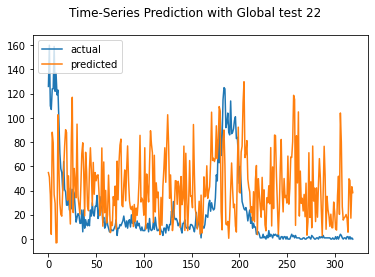

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_92_input (InputLayer)       [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_94_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_46 (Sequential)      (None, 1)            8492971     gru_92_input[0][0]               
__________________________________________________________________________________________________
sequential_47 (Sequential)      (None, 1)            5420971     gru_94_input[0][0]               
___________________________________________________________________________________________

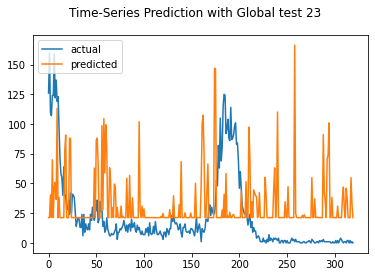

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_96_input (InputLayer)       [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_98_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_48 (Sequential)      (None, 1)            8492971     gru_96_input[0][0]               
__________________________________________________________________________________________________
sequential_49 (Sequential)      (None, 1)            5420971     gru_98_input[0][0]               
___________________________________________________________________________________________

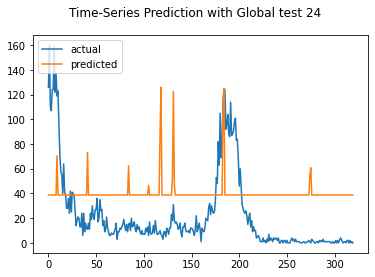

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_100_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_102_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_50 (Sequential)      (None, 1)            8492971     gru_100_input[0][0]              
__________________________________________________________________________________________________
sequential_51 (Sequential)      (None, 1)            5420971     gru_102_input[0][0]              
___________________________________________________________________________________________

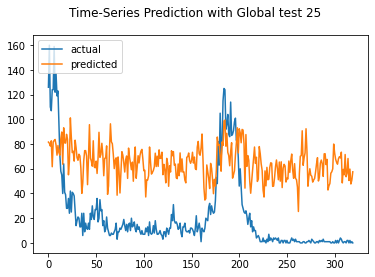

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_104_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_106_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_52 (Sequential)      (None, 1)            8492971     gru_104_input[0][0]              
__________________________________________________________________________________________________
sequential_53 (Sequential)      (None, 1)            5420971     gru_106_input[0][0]              
___________________________________________________________________________________________

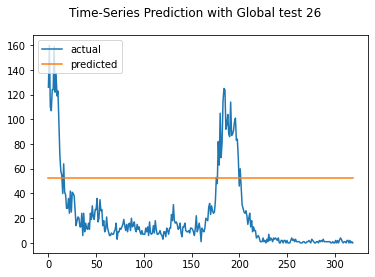

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_108_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_110_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_54 (Sequential)      (None, 1)            8492971     gru_108_input[0][0]              
__________________________________________________________________________________________________
sequential_55 (Sequential)      (None, 1)            5420971     gru_110_input[0][0]              
_______

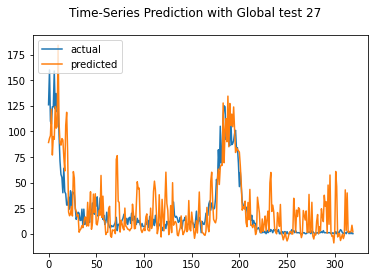

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_112_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_114_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_56 (Sequential)      (None, 1)            8492971     gru_112_input[0][0]              
__________________________________________________________________________________________________
sequential_57 (Sequential)      (None, 1)            5420971     gru_114_input[0][0]              
_______

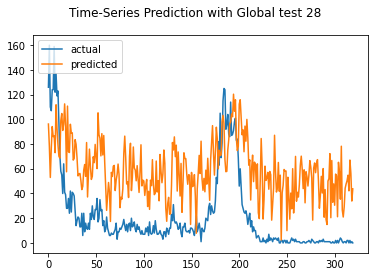

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_116_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_118_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_58 (Sequential)      (None, 1)            8492971     gru_116_input[0][0]              
__________________________________________________________________________________________________
sequential_59 (Sequential)      (None, 1)            5420971     gru_118_input[0][0]              
___________________________________________________________________________________________

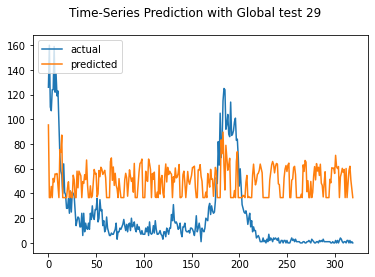

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_120_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_122_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_60 (Sequential)      (None, 1)            8492971     gru_120_input[0][0]              
__________________________________________________________________________________________________
sequential_61 (Sequential)      (None, 1)            5420971     gru_122_input[0][0]              
_______

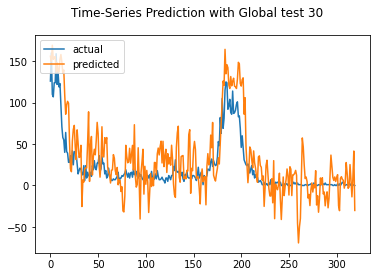

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_124_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_126_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_62 (Sequential)      (None, 1)            8492971     gru_124_input[0][0]              
__________________________________________________________________________________________________
sequential_63 (Sequential)      (None, 1)            5420971     gru_126_input[0][0]              
_______

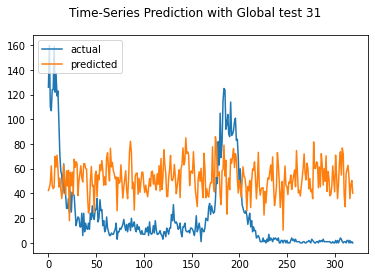

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Model: "model_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_128_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_130_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_64 (Sequential)      (None, 1)            8492971     gru_128_input[0][0]              
__________________________________________________________________________________________________
sequential_65 (Sequential)      (None, 1)            5420971     gru_130_input[0][0]              
_______

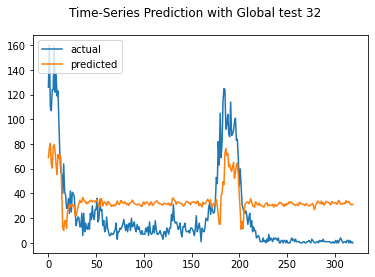

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_132_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_134_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_66 (Sequential)      (None, 1)            8492971     gru_132_input[0][0]              
__________________________________________________________________________________________________
sequential_67 (Sequential)      (None, 1)            5420971     gru_134_input[0][0]              
_______

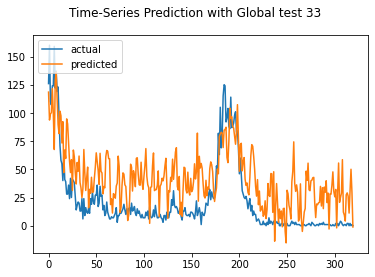

Model: "model_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_136_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_138_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_68 (Sequential)      (None, 1)            8492971     gru_136_input[0][0]              
__________________________________________________________________________________________________
sequential_69 (Sequential)      (None, 1)            5420971     gru_138_input[0][0]              
___________________________________________________________________________________________

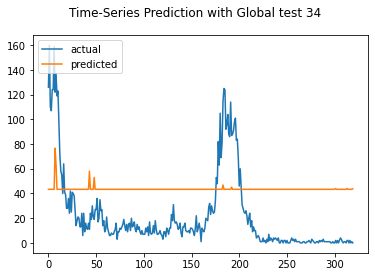

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_140_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_142_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_70 (Sequential)      (None, 1)            8492971     gru_140_input[0][0]              
__________________________________________________________________________________________________
sequential_71 (Sequential)      (None, 1)            5420971     gru_142_input[0][0]              
_______

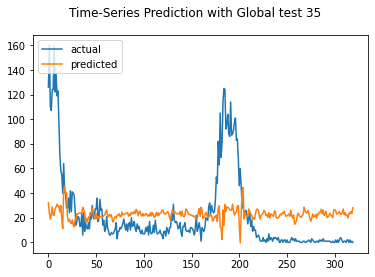

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Model: "model_36"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_144_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_146_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_72 (Sequential)      (None, 1)            8492971     gru_144_input[0][0]              
__________________________________________________________________________________________________
sequential_73 (Sequential)      (None, 1)            5420971     gru_146_input[0][0]              
_______

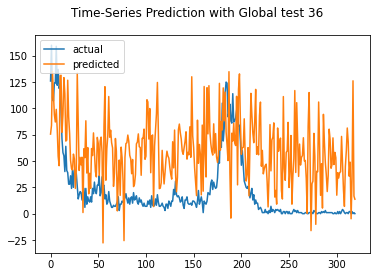

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_148_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_150_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_74 (Sequential)      (None, 1)            8492971     gru_148_input[0][0]              
__________________________________________________________________________________________________
sequential_75 (Sequential)      (None, 1)            5420971     gru_150_input[0][0]              
_______

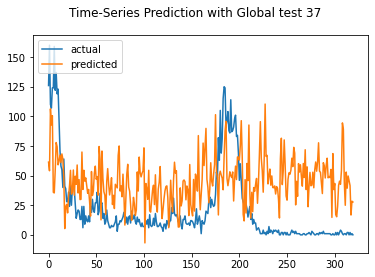

Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_152_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_154_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_76 (Sequential)      (None, 1)            8492971     gru_152_input[0][0]              
__________________________________________________________________________________________________
sequential_77 (Sequential)      (None, 1)            5420971     gru_154_input[0][0]              
___________________________________________________________________________________________

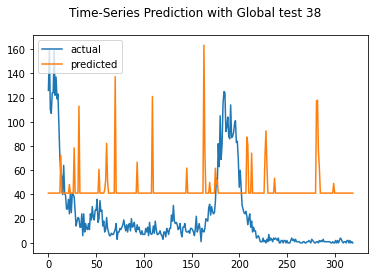

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Model: "model_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_156_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_158_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_78 (Sequential)      (None, 1)            8492971     gru_156_input[0][0]              
__________________________________________________________________________________________________
sequential_79 (Sequential)      (None, 1)            5420971     gru_158_input[0][0]              
_______

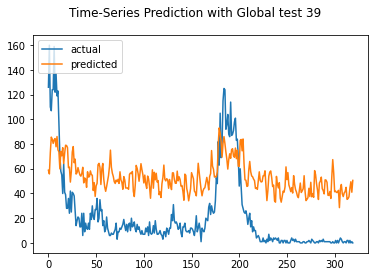

Model: "model_40"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_160_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_162_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_80 (Sequential)      (None, 1)            8492971     gru_160_input[0][0]              
__________________________________________________________________________________________________
sequential_81 (Sequential)      (None, 1)            5420971     gru_162_input[0][0]              
___________________________________________________________________________________________

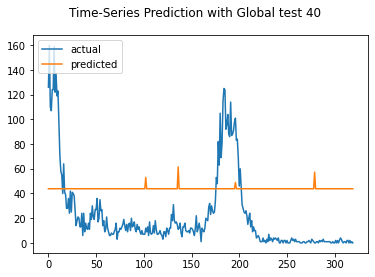

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_164_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_166_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_82 (Sequential)      (None, 1)            8492971     gru_164_input[0][0]              
__________________________________________________________________________________________________
sequential_83 (Sequential)      (None, 1)            5420971     gru_166_input[0][0]              
_______

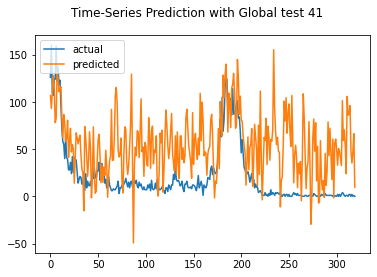

Model: "model_42"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_168_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_170_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_84 (Sequential)      (None, 1)            8492971     gru_168_input[0][0]              
__________________________________________________________________________________________________
sequential_85 (Sequential)      (None, 1)            5420971     gru_170_input[0][0]              
___________________________________________________________________________________________

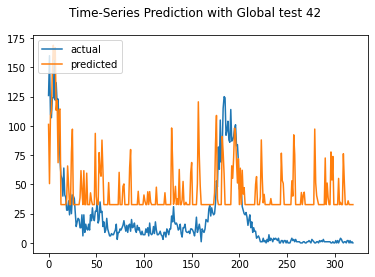

Model: "model_43"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_172_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_174_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_86 (Sequential)      (None, 1)            8492971     gru_172_input[0][0]              
__________________________________________________________________________________________________
sequential_87 (Sequential)      (None, 1)            5420971     gru_174_input[0][0]              
___________________________________________________________________________________________

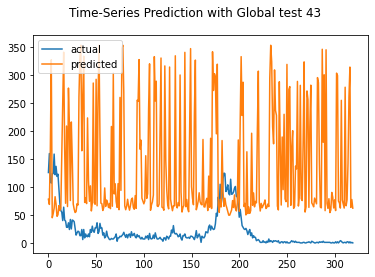

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Model: "model_44"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_176_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_178_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_88 (Sequential)      (None, 1)            8492971     gru_176_input[0][0]              
__________________________________________________________________________________________________
sequential_89 (Sequential)      (None, 1)            5420971     gru_178_input[0][0]              
_______

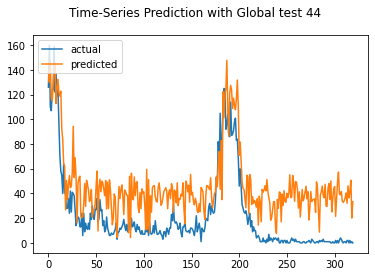

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Model: "model_45"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_180_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_182_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_90 (Sequential)      (None, 1)            8492971     gru_180_input[0][0]              
__________________________________________________________________________________________________
sequential_91 (Sequential)      (None, 1)            5420971     gru_182_input[0][0]              
_______

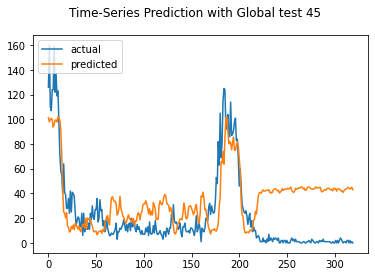

Model: "model_46"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_184_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_186_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_92 (Sequential)      (None, 1)            8492971     gru_184_input[0][0]              
__________________________________________________________________________________________________
sequential_93 (Sequential)      (None, 1)            5420971     gru_186_input[0][0]              
___________________________________________________________________________________________

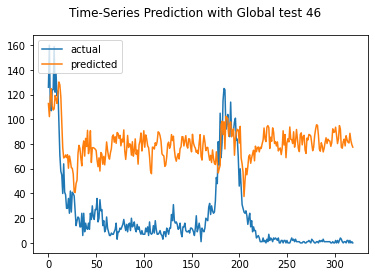

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Model: "model_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_188_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_190_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_94 (Sequential)      (None, 1)            8492971     gru_188_input[0][0]              
__________________________________________________________________________________________________
sequential_95 (Sequential)      (None, 1)            5420971     gru_190_input[0][0]              
_______

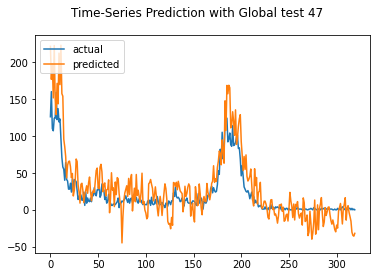

Model: "model_48"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_192_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_194_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_96 (Sequential)      (None, 1)            8492971     gru_192_input[0][0]              
__________________________________________________________________________________________________
sequential_97 (Sequential)      (None, 1)            5420971     gru_194_input[0][0]              
___________________________________________________________________________________________

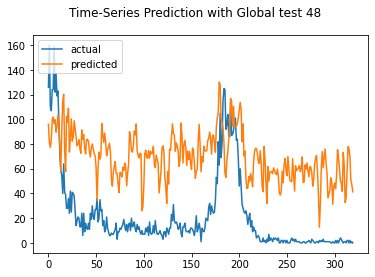

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Model: "model_49"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_196_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_198_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_98 (Sequential)      (None, 1)            8492971     gru_196_input[0][0]              
__________________________________________________________________________________________________
sequential_99 (Sequential)      (None, 1)            5420971     gru_198_input[0][0]              
_______

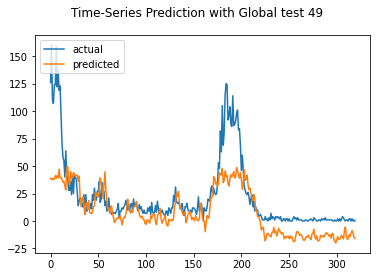

Model: "model_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_200_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_202_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_100 (Sequential)     (None, 1)            8492971     gru_200_input[0][0]              
__________________________________________________________________________________________________
sequential_101 (Sequential)     (None, 1)            5420971     gru_202_input[0][0]              
___________________________________________________________________________________________

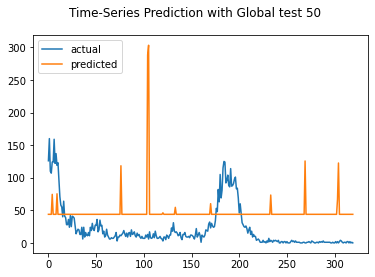

Model: "model_51"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_204_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_206_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_102 (Sequential)     (None, 1)            8492971     gru_204_input[0][0]              
__________________________________________________________________________________________________
sequential_103 (Sequential)     (None, 1)            5420971     gru_206_input[0][0]              
___________________________________________________________________________________________

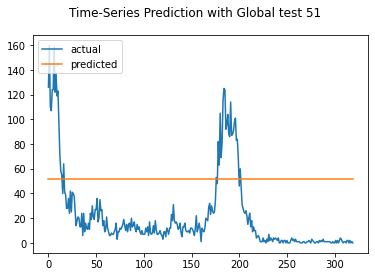

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Model: "model_52"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_208_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_210_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_104 (Sequential)     (None, 1)            8492971     gru_208_input[0][0]              
__________________________________________________________________________________________________
sequential_105 (Sequential)     (None, 1)            5420971     gru_210_input[0][0]              
_______

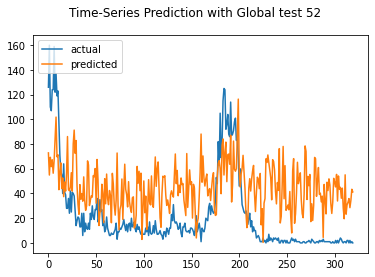

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Model: "model_53"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_212_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_214_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_106 (Sequential)     (None, 1)            8492971     gru_212_input[0][0]              
__________________________________________________________________________________________________
sequential_107 (Sequential)     (None, 1)            5420971     gru_214_input[0][0]              
_______

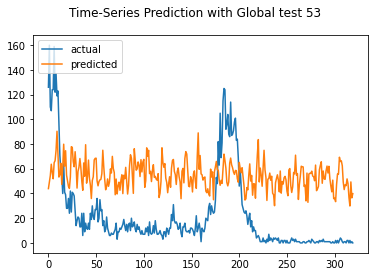

Model: "model_54"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_216_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_218_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_108 (Sequential)     (None, 1)            8492971     gru_216_input[0][0]              
__________________________________________________________________________________________________
sequential_109 (Sequential)     (None, 1)            5420971     gru_218_input[0][0]              
___________________________________________________________________________________________

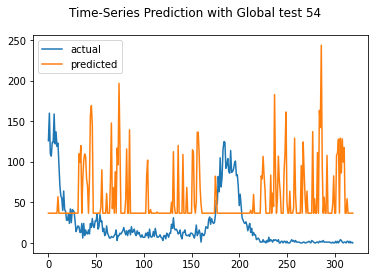

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Model: "model_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_220_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_222_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_110 (Sequential)     (None, 1)            8492971     gru_220_input[0][0]              
__________________________________________________________________________________________________
sequential_111 (Sequential)     (None, 1)            5420971     gru_222_input[0][0]              
_______

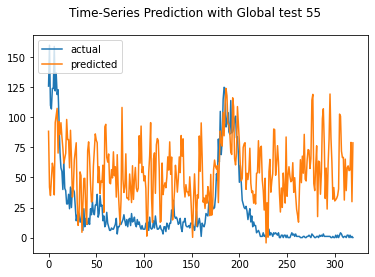

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Model: "model_56"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_224_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_226_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_112 (Sequential)     (None, 1)            8492971     gru_224_input[0][0]              
__________________________________________________________________________________________________
sequential_113 (Sequential)     (None, 1)            5420971     gru_226_input[0][0]              
_______

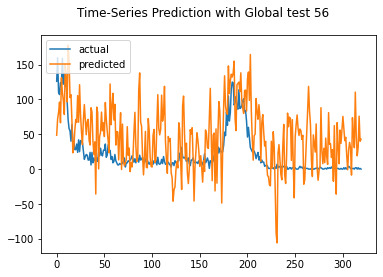

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Model: "model_57"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_228_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_230_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_114 (Sequential)     (None, 1)            8492971     gru_228_input[0][0]              
__________________________________________________________________________________________________
sequential_115 (Sequential)     (None, 1)            5420971     gru_230_input[0][0]              
_______

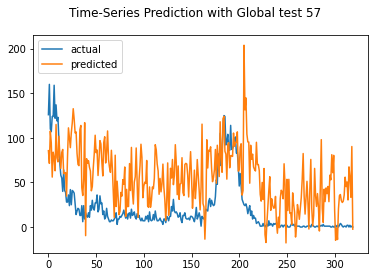

Model: "model_58"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_232_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_234_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_116 (Sequential)     (None, 1)            8492971     gru_232_input[0][0]              
__________________________________________________________________________________________________
sequential_117 (Sequential)     (None, 1)            5420971     gru_234_input[0][0]              
___________________________________________________________________________________________

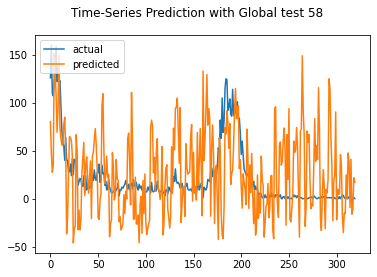

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Model: "model_59"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_236_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_238_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_118 (Sequential)     (None, 1)            8492971     gru_236_input[0][0]              
__________________________________________________________________________________________________
sequential_119 (Sequential)     (None, 1)            5420971     gru_238_input[0][0]              
_______

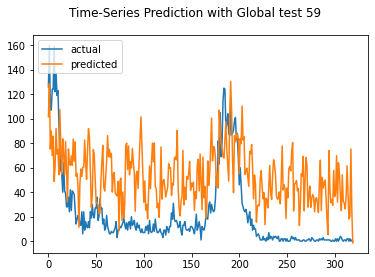

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Model: "model_60"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_240_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_242_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_120 (Sequential)     (None, 1)            8492971     gru_240_input[0][0]              
__________________________________________________________________________________________________
sequential_121 (Sequential)     (None, 1)            5420971     gru_242_input[0][0]              
_______

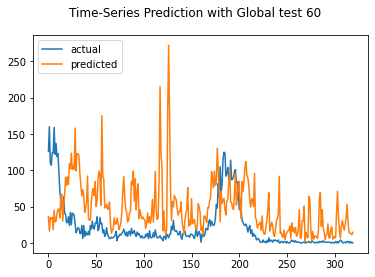

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Model: "model_61"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_244_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_246_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_122 (Sequential)     (None, 1)            8492971     gru_244_input[0][0]              
__________________________________________________________________________________________________
sequential_123 (Sequential)     (None, 1)            5420971     gru_246_input[0][0]              
_______

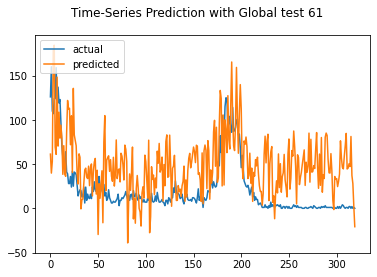

Model: "model_62"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_248_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_250_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_124 (Sequential)     (None, 1)            8492971     gru_248_input[0][0]              
__________________________________________________________________________________________________
sequential_125 (Sequential)     (None, 1)            5420971     gru_250_input[0][0]              
___________________________________________________________________________________________

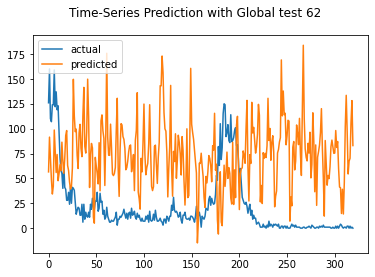

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Model: "model_63"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_252_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_254_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_126 (Sequential)     (None, 1)            8492971     gru_252_input[0][0]              
__________________________________________________________________________________________________
sequential_127 (Sequential)     (None, 1)            5420971     gru_254_input[0][0]              
_______

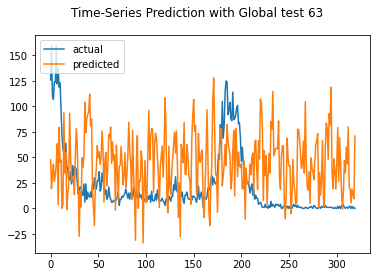

Model: "model_64"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_256_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_258_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_128 (Sequential)     (None, 1)            8492971     gru_256_input[0][0]              
__________________________________________________________________________________________________
sequential_129 (Sequential)     (None, 1)            5420971     gru_258_input[0][0]              
___________________________________________________________________________________________

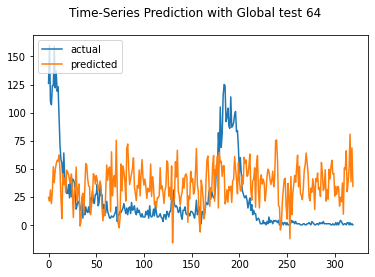

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Model: "model_65"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_260_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_262_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_130 (Sequential)     (None, 1)            8492971     gru_260_input[0][0]              
__________________________________________________________________________________________________
sequential_131 (Sequential)     (None, 1)            5420971     gru_262_input[0][0]              
_______

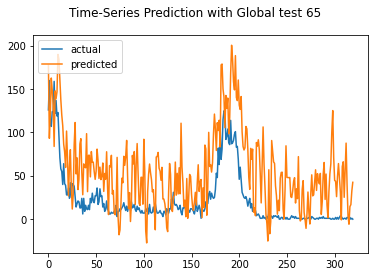

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Model: "model_66"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_264_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_266_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_132 (Sequential)     (None, 1)            8492971     gru_264_input[0][0]              
__________________________________________________________________________________________________
sequential_133 (Sequential)     (None, 1)            5420971     gru_266_input[0][0]              
_______

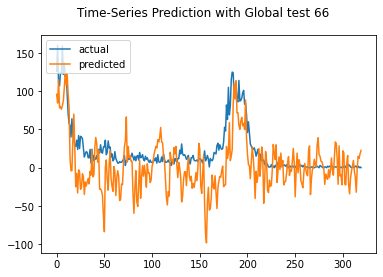

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Model: "model_67"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_268_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_270_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_134 (Sequential)     (None, 1)            8492971     gru_268_input[0][0]              
__________________________________________________________________________________________________
sequential_135 (Sequential)     (None, 1)            5420971     gru_270_input[0][0]              
_______

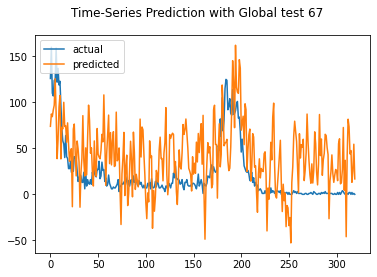

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Model: "model_68"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_272_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_274_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_136 (Sequential)     (None, 1)            8492971     gru_272_input[0][0]              
__________________________________________________________________________________________________
sequential_137 (Sequential)     (None, 1)            5420971     gru_274_input[0][0]              
_______

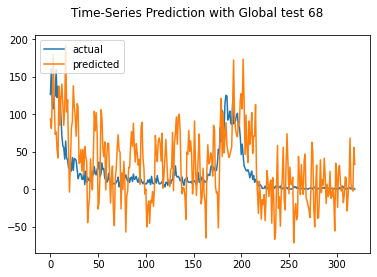

Model: "model_69"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_276_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_278_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_138 (Sequential)     (None, 1)            8492971     gru_276_input[0][0]              
__________________________________________________________________________________________________
sequential_139 (Sequential)     (None, 1)            5420971     gru_278_input[0][0]              
___________________________________________________________________________________________

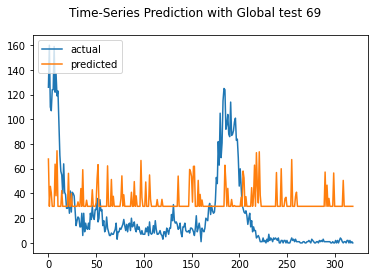

Model: "model_70"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_280_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_282_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_140 (Sequential)     (None, 1)            8492971     gru_280_input[0][0]              
__________________________________________________________________________________________________
sequential_141 (Sequential)     (None, 1)            5420971     gru_282_input[0][0]              
___________________________________________________________________________________________

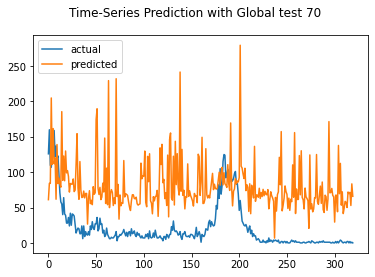

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Model: "model_71"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_284_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_286_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_142 (Sequential)     (None, 1)            8492971     gru_284_input[0][0]              
__________________________________________________________________________________________________
sequential_143 (Sequential)     (None, 1)            5420971     gru_286_input[0][0]              
_______

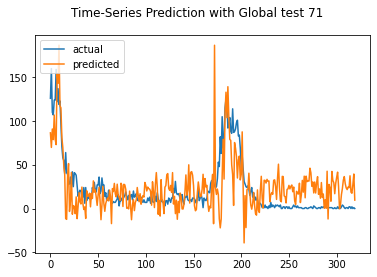

Model: "model_72"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_288_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_290_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_144 (Sequential)     (None, 1)            8492971     gru_288_input[0][0]              
__________________________________________________________________________________________________
sequential_145 (Sequential)     (None, 1)            5420971     gru_290_input[0][0]              
___________________________________________________________________________________________

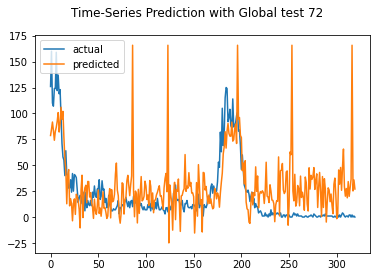

Model: "model_73"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_292_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_294_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_146 (Sequential)     (None, 1)            8492971     gru_292_input[0][0]              
__________________________________________________________________________________________________
sequential_147 (Sequential)     (None, 1)            5420971     gru_294_input[0][0]              
___________________________________________________________________________________________

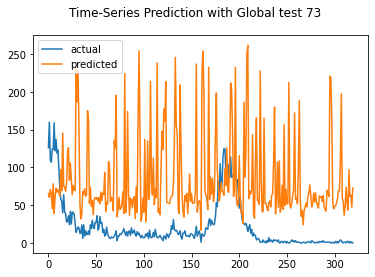

Model: "model_74"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_296_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_298_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_148 (Sequential)     (None, 1)            8492971     gru_296_input[0][0]              
__________________________________________________________________________________________________
sequential_149 (Sequential)     (None, 1)            5420971     gru_298_input[0][0]              
___________________________________________________________________________________________

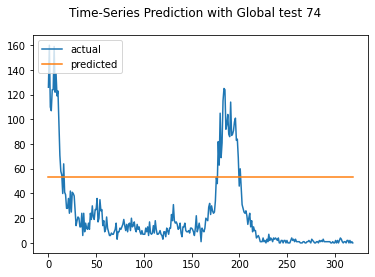

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Model: "model_75"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_300_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_302_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_150 (Sequential)     (None, 1)            8492971     gru_300_input[0][0]              
__________________________________________________________________________________________________
sequential_151 (Sequential)     (None, 1)            5420971     gru_302_input[0][0]              
_______

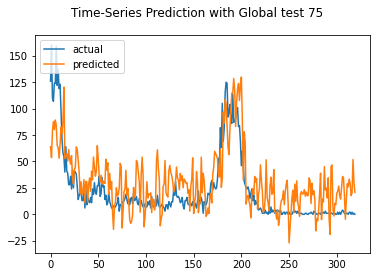

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Model: "model_76"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_304_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_306_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_152 (Sequential)     (None, 1)            8492971     gru_304_input[0][0]              
__________________________________________________________________________________________________
sequential_153 (Sequential)     (None, 1)            5420971     gru_306_input[0][0]              
_______

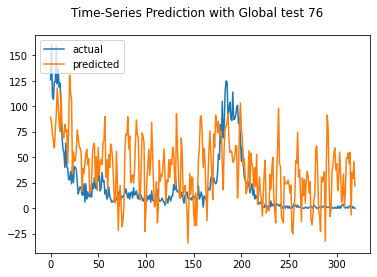

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Model: "model_77"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_308_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_310_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_154 (Sequential)     (None, 1)            8492971     gru_308_input[0][0]              
__________________________________________________________________________________________________
sequential_155 (Sequential)     (None, 1)            5420971     gru_310_input[0][0]              
_______

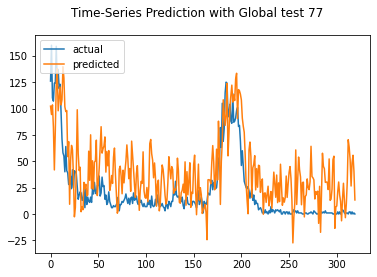

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Model: "model_78"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_312_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_314_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_156 (Sequential)     (None, 1)            8492971     gru_312_input[0][0]              
__________________________________________________________________________________________________
sequential_157 (Sequential)     (None, 1)            5420971     gru_314_input[0][0]              
_______

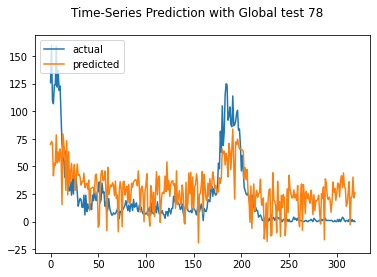

Model: "model_79"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_316_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_318_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_158 (Sequential)     (None, 1)            8492971     gru_316_input[0][0]              
__________________________________________________________________________________________________
sequential_159 (Sequential)     (None, 1)            5420971     gru_318_input[0][0]              
___________________________________________________________________________________________

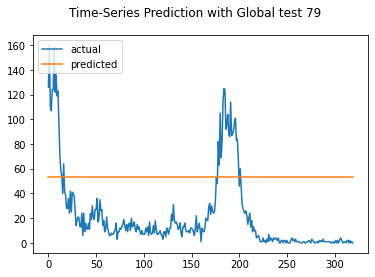

Model: "model_80"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_320_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_322_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_160 (Sequential)     (None, 1)            8492971     gru_320_input[0][0]              
__________________________________________________________________________________________________
sequential_161 (Sequential)     (None, 1)            5420971     gru_322_input[0][0]              
___________________________________________________________________________________________

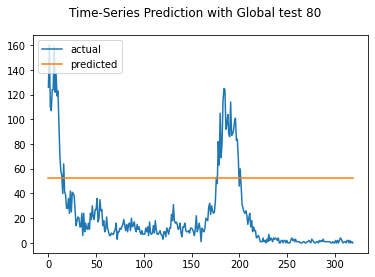

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Model: "model_81"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_324_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_326_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_162 (Sequential)     (None, 1)            8492971     gru_324_input[0][0]              
__________________________________________________________________________________________________
sequential_163 (Sequential)     (None, 1)            5420971     gru_326_input[0][0]              
_______

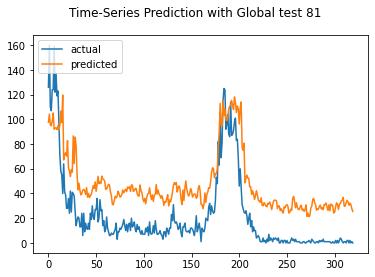

Model: "model_82"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_328_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_330_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_164 (Sequential)     (None, 1)            8492971     gru_328_input[0][0]              
__________________________________________________________________________________________________
sequential_165 (Sequential)     (None, 1)            5420971     gru_330_input[0][0]              
___________________________________________________________________________________________

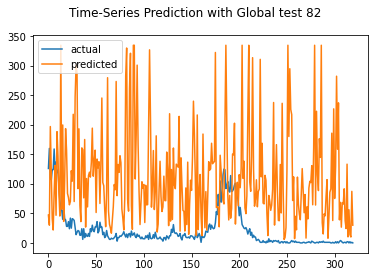

Model: "model_83"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_332_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_334_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_166 (Sequential)     (None, 1)            8492971     gru_332_input[0][0]              
__________________________________________________________________________________________________
sequential_167 (Sequential)     (None, 1)            5420971     gru_334_input[0][0]              
___________________________________________________________________________________________

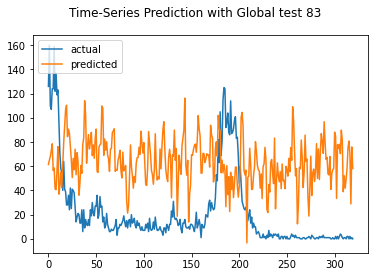

Model: "model_84"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_336_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_338_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_168 (Sequential)     (None, 1)            8492971     gru_336_input[0][0]              
__________________________________________________________________________________________________
sequential_169 (Sequential)     (None, 1)            5420971     gru_338_input[0][0]              
___________________________________________________________________________________________

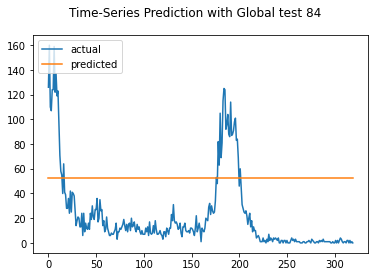

Model: "model_85"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_340_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_342_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_170 (Sequential)     (None, 1)            8492971     gru_340_input[0][0]              
__________________________________________________________________________________________________
sequential_171 (Sequential)     (None, 1)            5420971     gru_342_input[0][0]              
___________________________________________________________________________________________

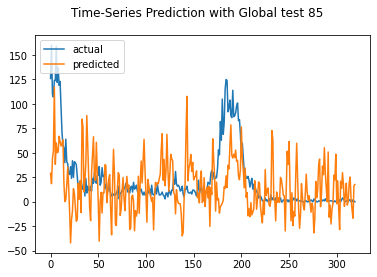

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Model: "model_86"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_344_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_346_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_172 (Sequential)     (None, 1)            8492971     gru_344_input[0][0]              
__________________________________________________________________________________________________
sequential_173 (Sequential)     (None, 1)            5420971     gru_346_input[0][0]              
_______

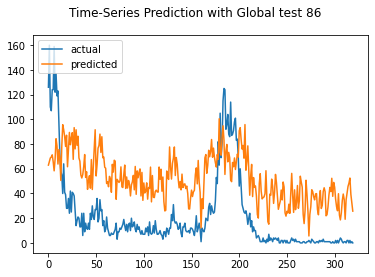

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Model: "model_87"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_348_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_350_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_174 (Sequential)     (None, 1)            8492971     gru_348_input[0][0]              
__________________________________________________________________________________________________
sequential_175 (Sequential)     (None, 1)            5420971     gru_350_input[0][0]              
_______

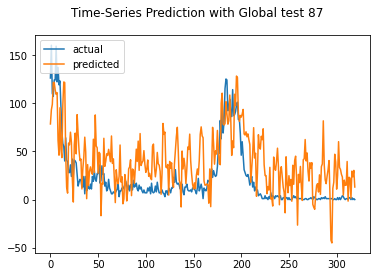

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Model: "model_88"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_352_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_354_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_176 (Sequential)     (None, 1)            8492971     gru_352_input[0][0]              
__________________________________________________________________________________________________
sequential_177 (Sequential)     (None, 1)            5420971     gru_354_input[0][0]              
_______

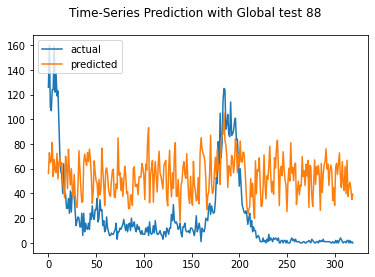

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Model: "model_89"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_356_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_358_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_178 (Sequential)     (None, 1)            8492971     gru_356_input[0][0]              
__________________________________________________________________________________________________
sequential_179 (Sequential)     (None, 1)            5420971     gru_358_input[0][0]              
_______

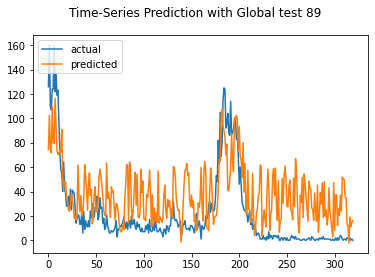

Model: "model_90"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_360_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_362_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_180 (Sequential)     (None, 1)            8492971     gru_360_input[0][0]              
__________________________________________________________________________________________________
sequential_181 (Sequential)     (None, 1)            5420971     gru_362_input[0][0]              
___________________________________________________________________________________________

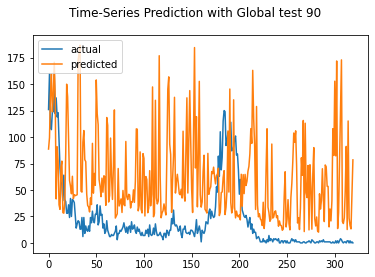

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Model: "model_91"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_364_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_366_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_182 (Sequential)     (None, 1)            8492971     gru_364_input[0][0]              
__________________________________________________________________________________________________
sequential_183 (Sequential)     (None, 1)            5420971     gru_366_input[0][0]              
_______

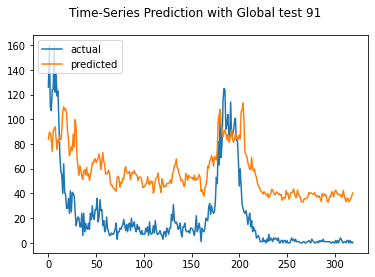

Model: "model_92"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_368_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_370_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_184 (Sequential)     (None, 1)            8492971     gru_368_input[0][0]              
__________________________________________________________________________________________________
sequential_185 (Sequential)     (None, 1)            5420971     gru_370_input[0][0]              
___________________________________________________________________________________________

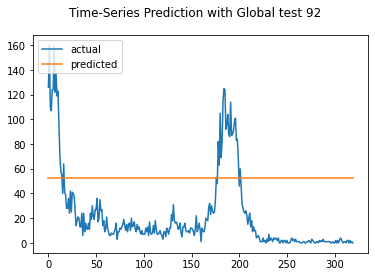

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Model: "model_93"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_372_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_374_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_186 (Sequential)     (None, 1)            8492971     gru_372_input[0][0]              
__________________________________________________________________________________________________
sequential_187 (Sequential)     (None, 1)            5420971     gru_374_input[0][0]              
_______

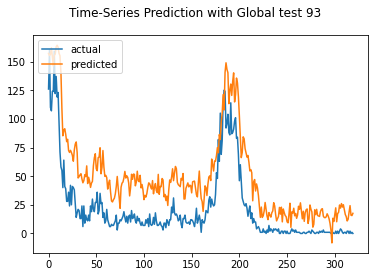

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Model: "model_94"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_376_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_378_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_188 (Sequential)     (None, 1)            8492971     gru_376_input[0][0]              
__________________________________________________________________________________________________
sequential_189 (Sequential)     (None, 1)            5420971     gru_378_input[0][0]              
_______

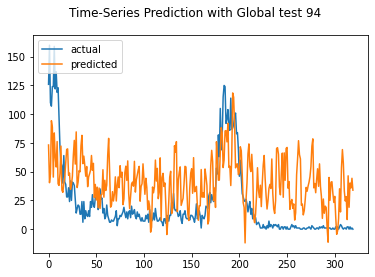

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Model: "model_95"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_380_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_382_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_190 (Sequential)     (None, 1)            8492971     gru_380_input[0][0]              
__________________________________________________________________________________________________
sequential_191 (Sequential)     (None, 1)            5420971     gru_382_input[0][0]              
_______

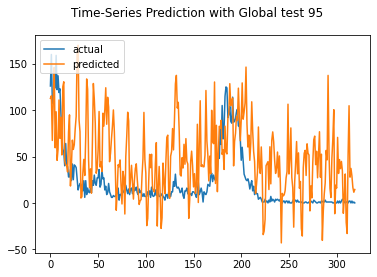

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Model: "model_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_384_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_386_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_192 (Sequential)     (None, 1)            8492971     gru_384_input[0][0]              
__________________________________________________________________________________________________
sequential_193 (Sequential)     (None, 1)            5420971     gru_386_input[0][0]              
_______

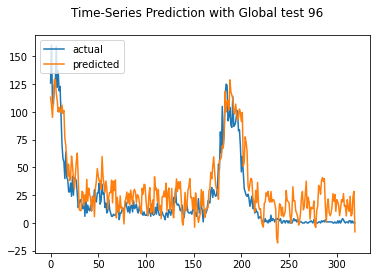

Model: "model_97"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_388_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_390_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_194 (Sequential)     (None, 1)            8492971     gru_388_input[0][0]              
__________________________________________________________________________________________________
sequential_195 (Sequential)     (None, 1)            5420971     gru_390_input[0][0]              
___________________________________________________________________________________________

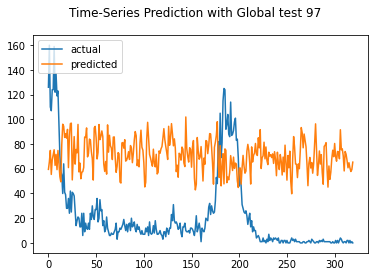

Model: "model_98"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_392_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_394_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_196 (Sequential)     (None, 1)            8492971     gru_392_input[0][0]              
__________________________________________________________________________________________________
sequential_197 (Sequential)     (None, 1)            5420971     gru_394_input[0][0]              
___________________________________________________________________________________________

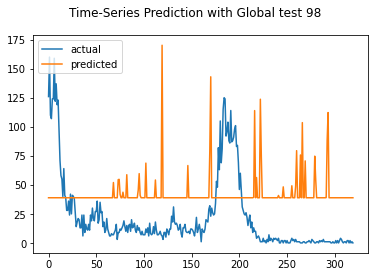

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Model: "model_99"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_396_input (InputLayer)      [(None, 3, 1025)]    0                                            
__________________________________________________________________________________________________
gru_398_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_198 (Sequential)     (None, 1)            8492971     gru_396_input[0][0]              
__________________________________________________________________________________________________
sequential_199 (Sequential)     (None, 1)            5420971     gru_398_input[0][0]              
_______

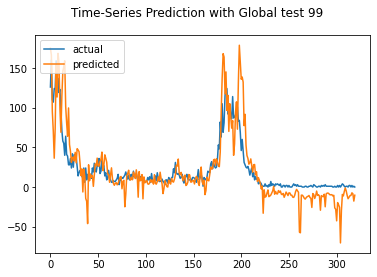

rmse : average=45.938, std=39.995
mae : average=39.174, std=34.280
smape : average=121.218, std=13.189
r2 : average=-2.671, std=15.484


([45.93778728560309, 39.995035239422684],
 [39.17433481206373, 34.27973811966314],
 [121.21819821173193, 13.188869396252214],
 [-2.670976671085051, 15.484050862545516])

In [13]:
# Use the Function:
sequence=train_X.shape[1]
features=train_X.shape[2]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global', fusion=fusion, x_ar=x_ar, x_ar_test=x_ar_test)


In [14]:
scalers['scaler_Labels'].inverse_transform(test_y).mean()

scalers['scaler_Labels'].inverse_transform(train_y).mean()

52.7